In [1]:
import os
os.chdir("/home/idpeshekhonov/AE")

In [2]:
# !pip install scikit-image
# import skimage

In [3]:
from src.model.Simple import SimpleAE
%load_ext autoreload
%autoreload 2
%matplotlib inline

import copy
import torch
import torch.nn as nn
import torchvision.transforms.functional as T
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from tqdm import tqdm

from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier

from pretrain import init, train
from configs import FCConfig, CAEConfig, MAEConfig, SimConfig
from src.data.collators import fc_collator, pretrain_collator, bw_collator
from src.utils.utils import set_random_seed

from src.model.FullyConnectedAE import FCAutoencoder
from src.model.ConvolutionalAE import CNNAutoencoder
from src.model.mae.MAE import MAE
from src.model.GANAE import GANAE, Descriminator

from src.data.dataset import get_train_dataset, get_val_dataset, SSLDataset, BlackWhiteDataset
from src.model.BWAE import BWAE
from train import init_classifier, train_classifier

plt.rcParams['font.size'] = 20

In [4]:
RANDOM_STATE = 322
set_random_seed(RANDOM_STATE)

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"


def draw_pretrain_plot(train_losses, val_losses):
    x = np.arange(len(train_losses))

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_losses, c="C0", label="train")
    plt.plot(x, val_losses, c="C1", label="val")
    plt.title("Pretrain model losses")
    plt.xlabel("Epoches")
    plt.ylabel("Loss")
    plt.semilogy()
    plt.legend()


@torch.no_grad()
def construct_grid(model, dataset, num_images=10, ids=None, f=None, collator=None, mae=False):
    if ids is None:
        ids = np.random.randint(0, len(dataset), size=num_images)
    img_batch = torch.Tensor().to(device)
    restored_img_batch = torch.Tensor().to(device)
    masked_batch = torch.Tensor().to(device)
    for idx in ids:
        img = dataset[idx]
        if collator is not None:
            img = collator([(img, _)])
        else:
            if type(img) == tuple:
                img = img[0]
            img = img.unsqueeze(0)
        img = img.to(device, non_blocking=True)
        restored_img = model(img)
        if f is not None:
            img = f(img).unsqueeze(0)
            restored_img = f(restored_img).unsqueeze(0)
        img_batch = torch.cat([img_batch, img], dim=0)
        restored_img_batch = torch.cat([restored_img_batch,
                                        restored_img], dim=0)

    img_batch = make_grid(img_batch.cpu(), nrow=num_images, padding=1, normalize=True, value_range=(-1, 1))
    restored_img_batch = make_grid(restored_img_batch.cpu(), nrow=num_images, padding=1, normalize=True,
                                   value_range=(-1, 1))
    if mae:
        masked_batch = make_grid(masked_batch.cpu(), nrow=num_images, padding=1, normalize=True, value_range=(-1, 1))
        grid = torch.cat([img_batch, masked_batch, restored_img_batch], dim=1)
    else:
        grid = torch.cat([img_batch, restored_img_batch], dim=1)
    return grid


def show_grid(grid, img_size=(5, 5)):
    fig, axs = plt.subplots(figsize=(5 * img_size[0], 5 * img_size[1]),
                            squeeze=False)
    grid = grid.detach()
    grid = T.to_pil_image(grid)
    axs[0, 0].imshow(grid)
    axs[0, 0].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


def pretrain(model, optimizer, criterion, scheduler, train_dataloader,
             val_dataloader, val_dataset, num_epoches, checkpoint_path, f=None, collator=None,
             mae=False):
    train_losses = []
    val_losses = []
    for epoch in range(num_epoches):
        train_loss, val_loss = train(model, optimizer, criterion, scheduler,
                                     train_dataloader, val_dataloader, checkpoint_path,
                                     device=device, num_epoches=1, scheduler_frequency="step")
        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())

        clear_output()
        draw_pretrain_plot(train_losses, val_losses)
        grid = construct_grid(model, val_dataset, f=f, collator=collator, mae=mae)
        show_grid(grid)
        plt.show()


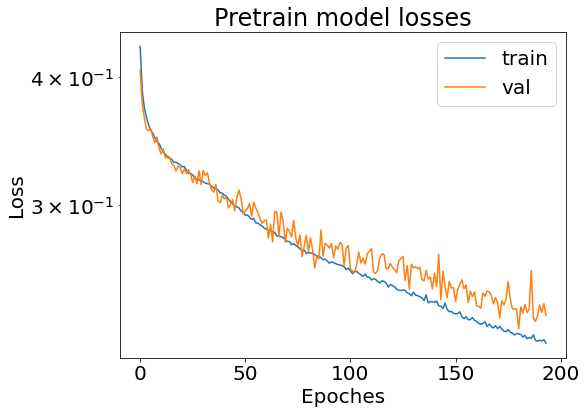

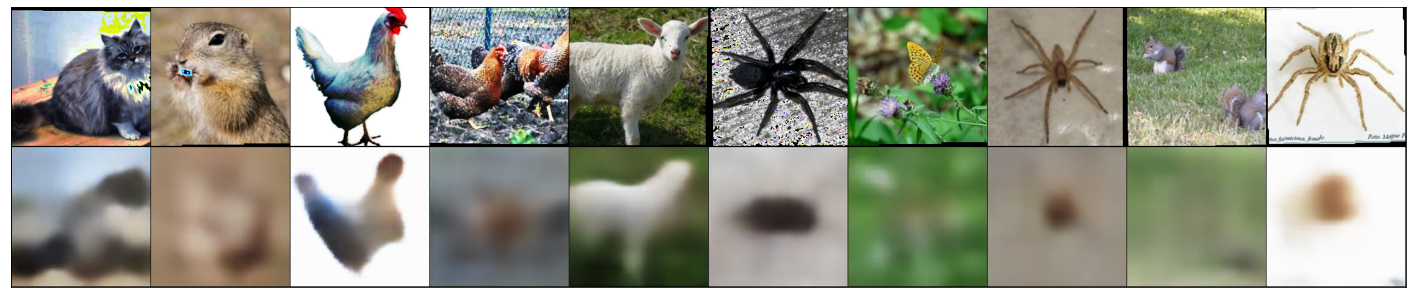

epoch loss: 0.22105810046195984:  97%|█████████▋| 565/583 [00:25<00:00, 23.51it/s]

In [ ]:
batch_size = 32
num_epoches = 400

model = GANAE(bw=False)
model.to(device)

train_dataset = SSLDataset("data/data/train/*", train=True, )
val_dataset = SSLDataset("data/data/train/labeled/*", train=False, labled=False)

train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True,
                              num_workers=6, pin_memory=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size, shuffle=False,
                            num_workers=6, pin_memory=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=3e-3, betas=(0.9, 0.999), eps=1e-6, weight_decay=5e-2)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, total_steps=len(train_dataloader) * num_epoches, max_lr=4e-3,
                                                anneal_strategy="cos", pct_start=0.05, div_factor=100)
# criterion = nn.MSELoss()
criterion = nn.L1Loss()


pretrain(model, optimizer, criterion, scheduler, train_dataloader, val_dataloader,
         val_dataset, num_epoches, "checkpoints/simple")

In [ ]:
def train_classifier(model, optimizer, criterion, scheduler, train_loader, checkpoint_path,
                     device="cpu", num_epoches=10):
    val_losses = []
    val_accs = []
    best_acc_value = 0
    for epoch in range(1, num_epoches + 1):
        losses = 0
        with tqdm(total=len(train_loader)) as prbar:
            for batch_idx, (features, targets) in enumerate(train_loader):
                features, targets = features.to("cuda", non_blocking=True), \
                                    targets.to("cuda", non_blocking=True)
                preds = model(features)
                loss = criterion(preds, targets)
                loss.backward()
                optimizer.step()

                optimizer.zero_grad()

                losses += loss.detach()
                prbar.set_description(f"Loss: {losses / batch_idx}")
                prbar.update(1)


In [18]:
batch_size = 128
device="cuda"

model = SimpleAE()
model.load_state_dict(torch.load("checkpoints/simple/final.pth")["model"])
model = model.encoder
for p in model.parameters():
    p.requires_grad_(False)
model = nn.Sequential(
    model,
    nn.Linear(512, 10)
).to(device)

train_dataset = SSLDataset("data/data/train/labeled", labled=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=6, pin_memory=True)
# val_dataset = SSLDataset("data/data/test")
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=6, pin_memory=True)
print( len(train_dataset) // batch_size)

opt = torch.optim.AdamW(model.parameters(), lr=4e-3, betas=(0.9, 0.999), eps=1e-6, weight_decay=5e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, len(train_dataset) // batch_size)
criterion = nn.CrossEntropyLoss(label_smoothing=.1)

train_classifier(model, opt, criterion, scheduler, train_loader, None, device, 20)

16


Loss: 2.1479907035827637: 100%|██████████| 17/17 [00:04<00:00,  3.78it/s]


In [19]:
for p in model.parameters():
    p.requires_grad_(True)

opt = torch.optim.AdamW(model.parameters(), lr=1e-5, betas=(0.9, 0.999), eps=1e-6, weight_decay=5e-2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, len(train_dataset) // batch_size)
criterion = nn.CrossEntropyLoss(label_smoothing=.1)

train_classifier(model, opt, criterion, scheduler, train_loader, None, device, 20)

Loss: 2.09041690826416: 100%|██████████| 17/17 [00:05<00:00,  3.02it/s]  


In [20]:
import glob
from skimage import io

with open("submission.csv", "w") as f:
    f.write("id,class\n")
    imgs = list(glob.iglob("data/data/train/test/*.jpg", recursive=True))
    for img in tqdm(imgs, desc="Dataset loading"):
        image = io.imread(img)
        image = val_dataset.transforms(image).to(device)
        cls = model(image.unsqueeze(0)).argmax()
        f.write(img[img.rfind("/")+1 :] + f",{train_dataset.data.classes[cls]}\n")

Dataset loading: 100%|██████████| 2050/2050 [01:36<00:00, 21.19it/s]
